In [32]:
# Load data
import scipy
import numpy as np

mnist = scipy.io.loadmat('/Users/pranavreddy/Desktop/ECE 174/Project1/mnist.mat')

trainX = np.array(mnist['trainX'])
trainY = np.array(mnist['trainY']).transpose().astype(int)

# Process data – normalize and augment with 1's column
trainX = trainX / np.max(trainX)
n = (trainX.shape)[0]
trainX = np.hstack((np.ones((n,1)), trainX))

In [33]:
# Pre-compute least squares matrices

XTX = np.matmul(trainX.transpose(), trainX)
XTX_pinv = np.linalg.pinv(XTX)
XTX_pinv_XT = np.matmul(XTX_pinv,trainX.transpose())

In [34]:
# Construct models
labels = np.arange(0, 10)

one_vs_all_model = []
for i in range(len(labels)):
    binaryY = np.copy(trainY)
    binaryY[binaryY != labels[i]] = -1
    binaryY[binaryY == labels[i]] = 1
    
    one_vs_all_model.append(np.matmul(XTX_pinv_XT,binaryY))
# Stack models in matrix – ith column is binary classifier for ith label
one_vs_all_model=np.concatenate(one_vs_all_model,axis=1)


In [35]:
# Load and process test data
testX = np.array(mnist['testX']).astype(float)
testY = np.array(mnist['testY']).transpose()

testX = testX / np.max(testX)
n = (testX.shape)[0]
testX = np.hstack((np.ones((n,1)), testX))

# Generate train and test predictions
one_vs_all_train_predictions = np.matmul(trainX, one_vs_all_model)
one_vs_all_train_predictions=np.argmax(one_vs_all_train_predictions, axis=1)

one_vs_all_test_predictions = np.matmul(testX, one_vs_all_model)
one_vs_all_test_predictions = np.argmax(one_vs_all_test_predictions, axis=1)


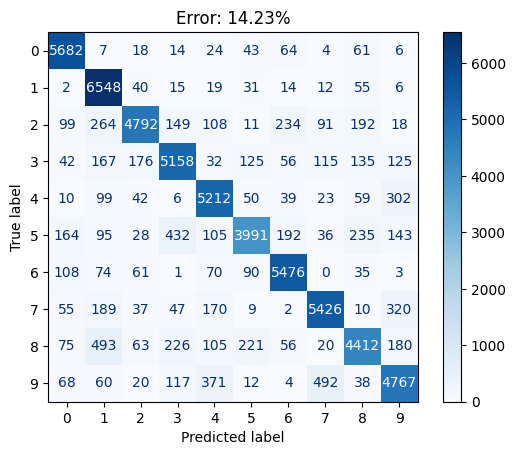

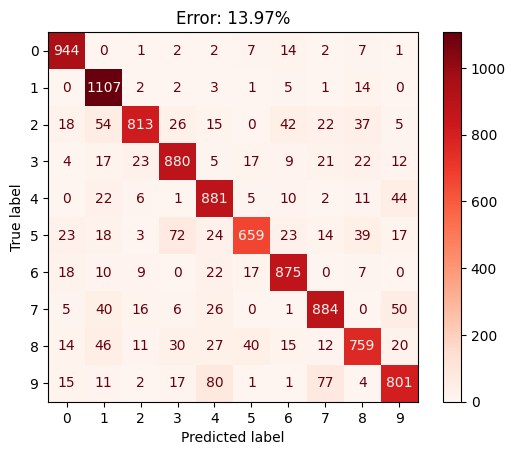

In [36]:
# Plot confusion matrices using sklearn libraries
from sklearn import metrics
import matplotlib.pyplot as plt

# Compute error rates
one_vs_all_train_error = 0
one_vs_all_test_error = 0

for i in range(len(trainY)):
    if(one_vs_all_train_predictions[i] != trainY[i]):
        one_vs_all_train_error = one_vs_all_train_error + 1
for i in range(len(testY)):
    if(one_vs_all_test_predictions[i] != testY[i]):
        one_vs_all_test_error = one_vs_all_test_error + 1
one_vs_all_train_error = (one_vs_all_train_error / len(trainY)) * 100
one_vs_all_test_error = (one_vs_all_test_error / len(testY)) * 100

one_vs_all_train_confusion_matrix_display=metrics.ConfusionMatrixDisplay.from_predictions(trainY, one_vs_all_train_predictions, cmap='Blues')
plt.title(f'Error: {one_vs_all_train_error:.2f}%')
plt.show()
one_vs_all_train_confusion_matrix_display.figure_.savefig('/Users/pranavreddy/Desktop/ECE 174/Project1/images/one_vs_all_train_confusion_matrix.eps')
one_vs_all_test_confusion_matrix_display=metrics.ConfusionMatrixDisplay.from_predictions(testY, one_vs_all_test_predictions, cmap='Reds')
plt.title(f'Error: {one_vs_all_test_error:.2f}%')
plt.show()
one_vs_all_test_confusion_matrix_display.figure_.savefig('/Users/pranavreddy/Desktop/ECE 174/Project1/images/one_vs_all_test_confusion_matrix.eps')

In [37]:
# Compute one-vs-one model as a 10x10x785 array
one_vs_one_model = np.empty((10,10,trainX.shape[1]))

for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        mask = ((trainY[:,0] == labels[i]) | (trainY[:,0] == labels[j]))
        filtered_Y = trainY[mask]
        filtered_X = trainX[mask]

        filtered_Y[filtered_Y == labels[j]] = -1
        filtered_Y[filtered_Y == labels[i]] = 1
        model_ij = np.matmul(np.matmul(np.linalg.pinv(np.matmul(filtered_X.transpose(),filtered_X)),filtered_X.transpose()),filtered_Y)
        one_vs_one_model[i,j,:] = model_ij[:,0]

In [38]:
# Tally "votes" for each label using model
votes = np.zeros((trainX.shape[0], labels.shape[0]))

for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        prediction_ij = np.matmul(trainX, one_vs_one_model[i,j,:])
        votes[prediction_ij > 0,i] = votes[prediction_ij > 0,i] + 1
        votes[prediction_ij < 0,j] = votes[prediction_ij < 0,j] + 1
# See which label has the most votes
one_vs_one_train_predictions = np.argmax(votes, axis=1)

# Repeat voting for test data
votes = np.zeros((testX.shape[0], labels.shape[0]))

for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        prediction_ij = np.matmul(testX, one_vs_one_model[i,j,:])
        votes[prediction_ij > 0,i] = votes[prediction_ij > 0,i] + 1
        votes[prediction_ij < 0,j] = votes[prediction_ij < 0,j] + 1

one_vs_one_test_predictions = np.argmax(votes, axis=1)

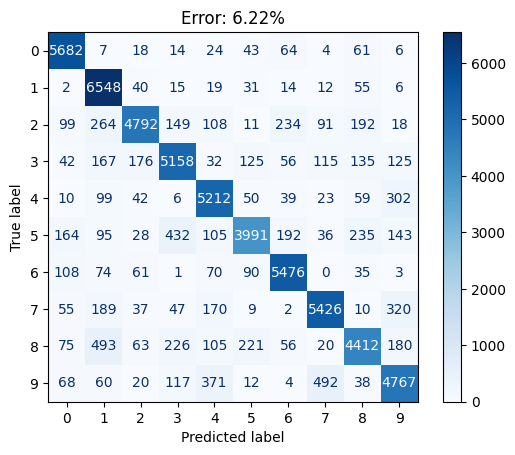

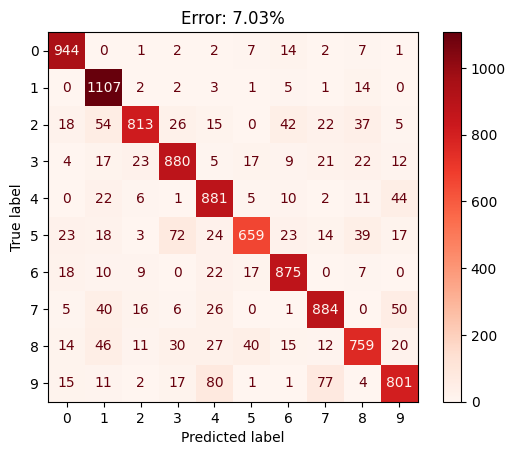

In [39]:
# Compute error
one_vs_one_train_error = 0
one_vs_one_test_error = 0

for i in range(len(trainY)):
    if(one_vs_one_train_predictions[i] != trainY[i]):
        one_vs_one_train_error = one_vs_one_train_error + 1
for i in range(len(testY)):
    if(one_vs_one_test_predictions[i] != testY[i]):
        one_vs_one_test_error = one_vs_one_test_error + 1
one_vs_one_train_error = (one_vs_one_train_error / len(trainY)) * 100
one_vs_one_test_error = (one_vs_one_test_error / len(testY)) * 100

# Use sklearn and matplotlib to plot confusion matrices

one_vs_one_train_confusion_matrix_display=metrics.ConfusionMatrixDisplay.from_predictions(trainY, one_vs_all_train_predictions, cmap='Blues')
plt.title(f'Error: {one_vs_one_train_error:.2f}%')
plt.show()
one_vs_one_train_confusion_matrix_display.figure_.savefig('/Users/pranavreddy/Desktop/ECE 174/Project1/images/one_vs_one_train_confusion_matrix.eps')
one_vs_one_test_confusion_matrix_display=metrics.ConfusionMatrixDisplay.from_predictions(testY, one_vs_all_test_predictions, cmap='Reds')
plt.title(f'Error: {one_vs_one_test_error:.2f}%')
plt.show()
one_vs_one_test_confusion_matrix_display.figure_.savefig('/Users/pranavreddy/Desktop/ECE 174/Project1/images/one_vs_one_test_confusion_matrix.eps')